# Healthcare Appointment No-Show Prediction Task 

### Import packages

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import chi2
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (classification_report, accuracy_score,  roc_curve, roc_auc_score, f1_score, make_scorer, 
                             precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

## Upload the data

In [167]:
df = pd.read_csv('appointment_data.csv')

In [168]:
df.shape

(5000, 18)

In [169]:
df.head(7)

,PatientID,AppointmentID,Gender,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Disability,SMS_received,AppointmentDay,ScheduledDay,DayOfWeek,AppointmentTime,WaitingTime,PreviousNoShows,NoShow
0,861,1,Female,28,Westside,0,0,0,0,1,0,2023-11-29,2023-11-20,Wednesday,15:00,9,1,0
1,1295,2,Female,71,Eastview,0,0,0,0,0,1,2023-12-06,2023-11-29,Wednesday,10:00,7,0,0
2,1131,3,Male,32,Hillcrest,1,0,0,1,0,0,2023-12-05,2023-11-23,Tuesday,16:45,12,1,0
3,1096,4,Female,34,Southpark,0,0,0,0,0,0,2023-10-08,2023-10-07,Sunday,17:30,1,0,0
4,1639,5,Male,30,Pinegrove,0,1,0,0,0,0,2023-09-09,2023-08-16,Saturday,10:15,24,1,0
5,2170,6,Female,71,Maplewood,0,0,1,0,0,1,2023-10-10,2023-09-24,Tuesday,11:00,16,0,0
6,467,7,Female,53,Hillcrest,1,1,0,0,0,1,2023-09-25,2023-09-21,Monday,13:45,4,0,0


## Preliminary analysis of the data, getting a sense of what data we have

In [170]:
#Check how many neighborhoods are included in the data
df['Neighborhood'].unique()

array(['Westside', 'Eastview', 'Hillcrest', 'Southpark', 'Pinegrove',
       'Maplewood', 'Downtown', 'Northend', 'Oakdale', 'Riverside'],
      dtype=object)

We have 10 neighborhoods, which are including in this data 

In [171]:
df['AppointmentTime'].unique()

array(['15:00', '10:00', '16:45', '17:30', '10:15', '11:00', '13:45',
       '14:00', '15:15', '14:15', '10:30', '09:45', '09:15', '16:00',
       '12:45', '13:30', '17:45', '11:15', '08:30', '14:30', '11:45',
       '15:45', '08:15', '14:45', '12:00', '12:30', '12:15', '10:45',
       '11:30', '08:45', '16:30', '16:15', '17:15', '09:00', '17:00',
       '13:15', '15:30', '08:00', '13:00', '09:30'], dtype=object)

In [172]:
sorted_times = sorted(df['AppointmentTime'].unique(), key=lambda x: pd.to_datetime(x, format='%H:%M').time())
print(f'opening hour: {sorted_times[0]}')
print(f'closing hour: {sorted_times[-1]}')

opening hour: 08:00
closing hour: 17:45


We can see that the appointments start from 9:00 untill 18:00. And each is supposed to start at either :00, :15, :30 or :45 (supposedly, each appointment is 15 min long).

In [173]:
len(df['PatientID'].unique())

2400

this means that out of 5000 records, there are 2400 patients, i.e. there are patients who registered for their appointment more than once

Now let's see how often there are missing values for each column

In [174]:
for col in df.columns:
    print(col)
    print(df[col].isin(['', ' ', 'None', 'NaN', 'null', None]).sum())

PatientID
0
AppointmentID
0
Gender
0
Age
0
Neighborhood
0
Scholarship
0
Hypertension
0
Diabetes
0
Alcoholism
0
Disability
0
SMS_received
0
AppointmentDay
0
ScheduledDay
0
DayOfWeek
0
AppointmentTime
0
WaitingTime
0
PreviousNoShows
0
NoShow
0


In [175]:
missing_info = df.isnull().sum().to_frame(name='MissingValues')
missing_info['Percentage'] = (missing_info['MissingValues'] / len(df)) * 100
print(missing_info)

                 MissingValues  Percentage
PatientID                    0         0.0
AppointmentID                0         0.0
Gender                       0         0.0
Age                          0         0.0
Neighborhood                 0         0.0
Scholarship                  0         0.0
Hypertension                 0         0.0
Diabetes                     0         0.0
Alcoholism                   0         0.0
Disability                   0         0.0
SMS_received                 0         0.0
AppointmentDay               0         0.0
ScheduledDay                 0         0.0
DayOfWeek                    0         0.0
AppointmentTime              0         0.0
WaitingTime                  0         0.0
PreviousNoShows              0         0.0
NoShow                       0         0.0


It seems like we don't really have missing values in our dataframe.

In [176]:
print(f'Youngest patient: {min(df.Age)}')
print(f'Oldest patient: {max(df.Age)}')

Youngest patient: 0
Oldest patient: 95


Our age range of patients is from 0 to 95 years old.

## Making plots that preliminarily show which parameters can potentially affect the NoShow parameter

### Scholarship, hypertension, diabetes, alcoholism, disability, SMS_received

First, let's do for binary columns regarding binary conditions/health problems (those who have values 0 and 1 - no, yes)

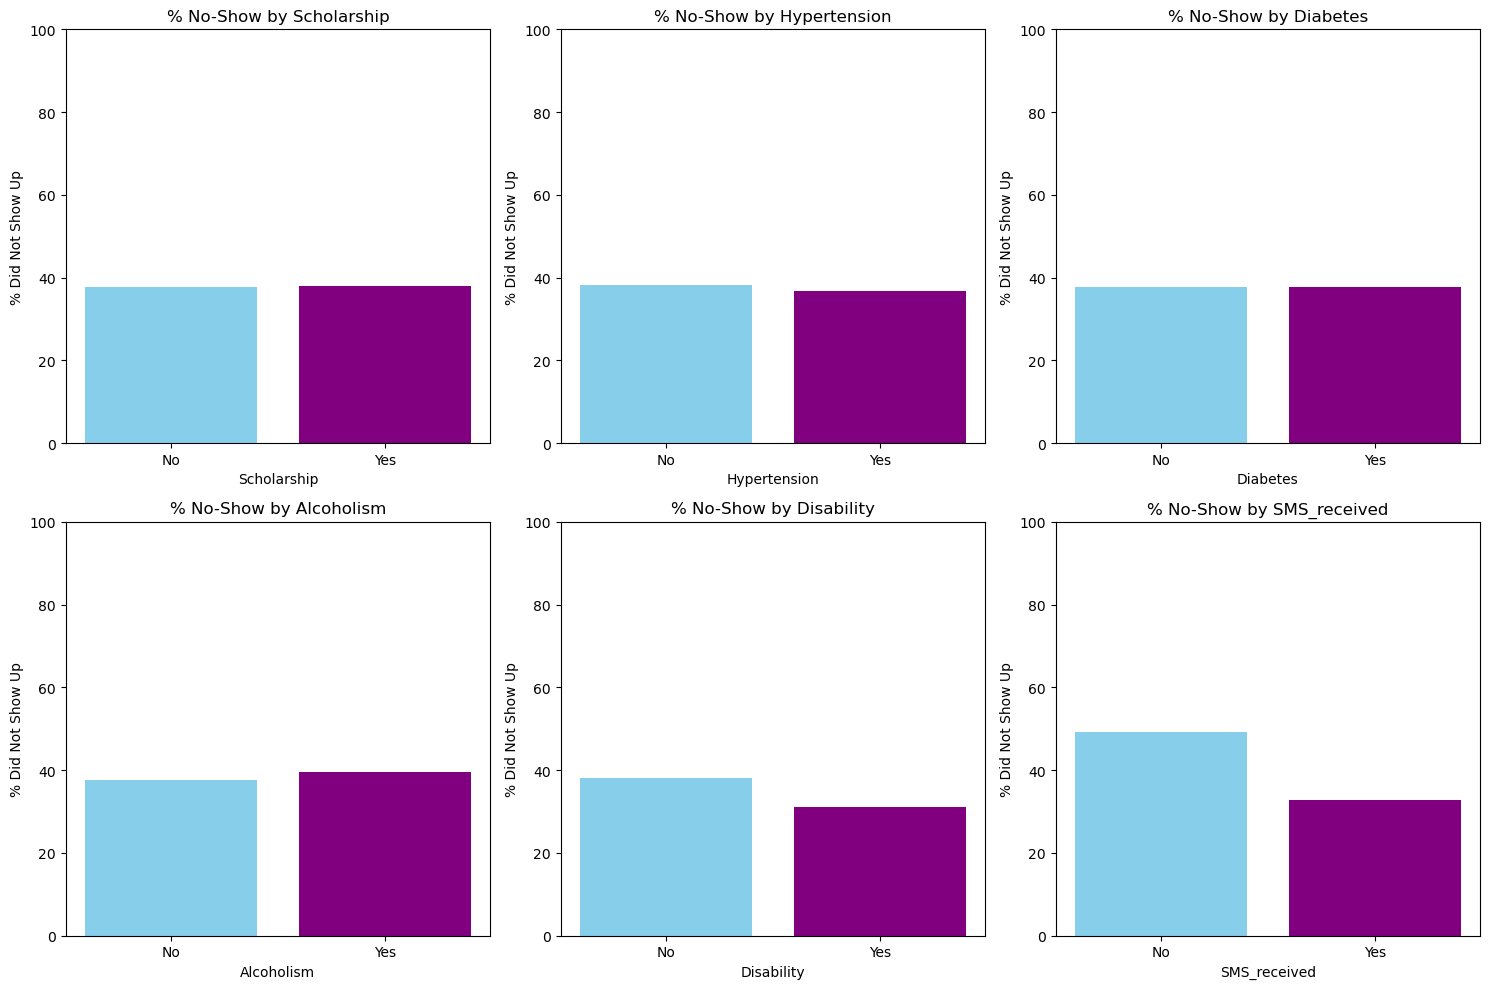

In [177]:
binary_columns = ['Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Disability', 'SMS_received']

n_cols = 3
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(binary_columns):
    group_counts = df.groupby(col)['NoShow'].value_counts(normalize=True).unstack().fillna(0)
    noshow_percent = group_counts[1] * 100  # Get % of NoShow=1 for each group

    # Plot
    axes[i].bar(['No', 'Yes'], noshow_percent.values, color=['skyblue', 'purple'])
    axes[i].set_title(f'% No-Show by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('% Did Not Show Up')
    axes[i].set_ylim(0, 100) # we want the plots to show us the percentages untill 100%, so we can compare them with each other 

plt.tight_layout()
plt.show()

The plots above show the percentage of people who didn't show up for their appointmets, where each bar represents the parameter whether it's no or yes (e.g. whether the person had a scholarship or no). 

We can see minor differences with Disability and SMS_received, but we see this 'by eye' and need a more reliable way to see whether there is a statistical difference.

Since, these are categorical values, we can use logistic regression to predict whether the parameter affects the probability that the patient won't show up.

In [178]:
X_1 = df[['Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Disability', 'SMS_received']]
X_1 = sm.add_constant(X_1)
y = df['NoShow']

model_1 = sm.Logit(y, X_1).fit()
print(model_1.summary())

Optimization terminated successfully.
         Current function value: 0.650145
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 NoShow   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4993
Method:                           MLE   Df Model:                            6
Date:                Wed, 16 Apr 2025   Pseudo R-squ.:                 0.01861
Time:                        21:11:16   Log-Likelihood:                -3250.7
converged:                       True   LL-Null:                       -3312.4
Covariance Type:            nonrobust   LLR p-value:                 3.288e-24
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0062      0.060     -0.103      0.918      -0.125       0.112
Scholarship      0.0024

Here, the valueable results are the coefficient, which shows whether the probability of NoShow increases or decreases depending on the parameter (positive value means increase and the negative value means dicrease).

And the key value - the p-value. If it's less than 0.05 -> the result statistically significant, if more than 0.05 - then it's not.

By the table, we see that p-value (P>|z|) is less than 0.05 for Disability and SMS_received - where the coef is negative, especially for the SMS_received (and p-value is very very small there, but not zero!).

This means, that according to the logistic regression model, the presence of Disability or receiving SMS decreases the chances of the patient not showing up. This is an important information, as it helps us understand the overall picture better and will later help us construct a better prediction model.

We can interpret this as following: ff the person has a disability, they are less likely to miss their appointment as (maybe) they have bigger health concerns, so more motivation to come to their appointment. Also, if the person has received an SMS reminder, they're less likely to miss their appointment because it reduces the chances that the person will forget about their upcoming appointment.

### Gender, age, neighborhood and day of the week

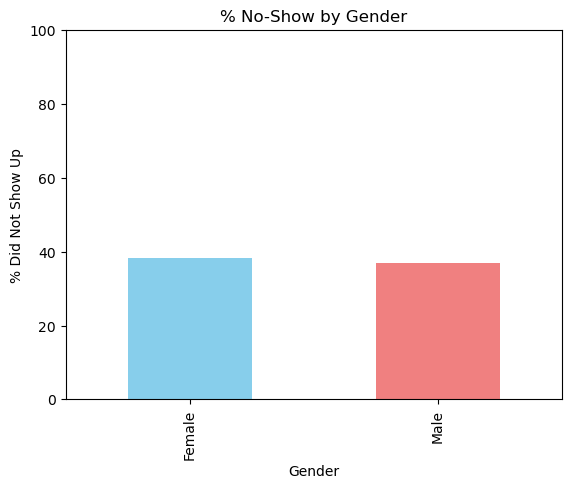

In [179]:
gender_pct = df.groupby('Gender')['NoShow'].mean() * 100
gender_pct.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('% No-Show by Gender')
plt.ylabel('% Did Not Show Up')
plt.xlabel('Gender')
plt.ylim(0, 100)
plt.show()

We don't really see any difference between female and male in terms of No-Show.

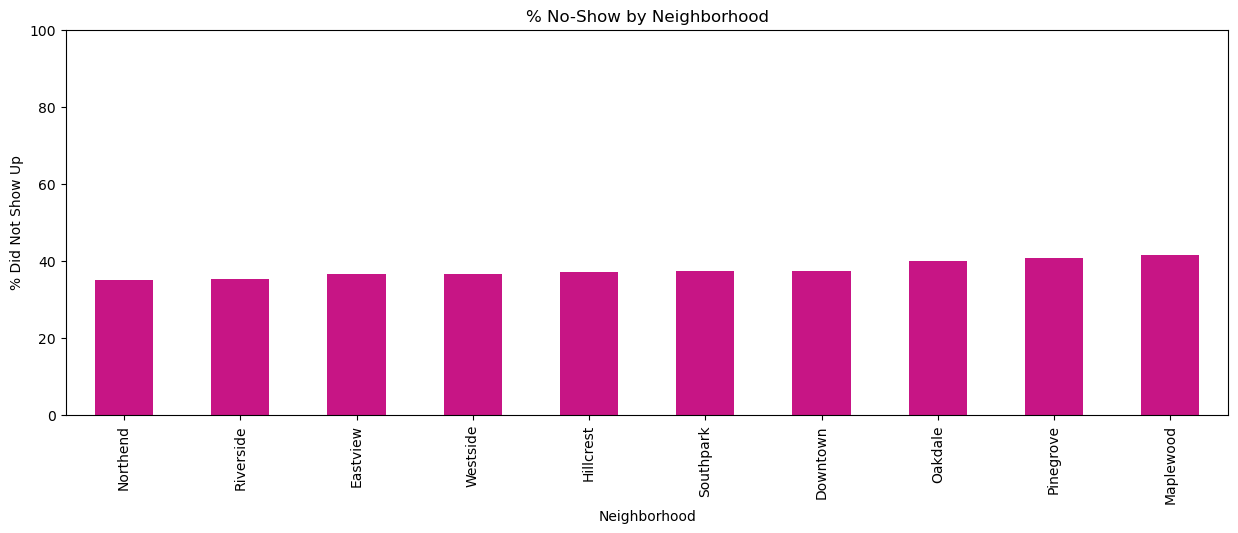

In [180]:
neigh_pct = df.groupby('Neighborhood')['NoShow'].mean().sort_values() * 100
neigh_pct.plot(kind='bar', figsize=(15, 5), color='mediumvioletred')
plt.title('% No-Show by Neighborhood')
plt.ylabel('% Did Not Show Up')
plt.xlabel('Neighborhood')
plt.xticks(rotation=90)
plt.ylim(0, 100)
plt.show()

We don't really see much difference in the neighbood either.

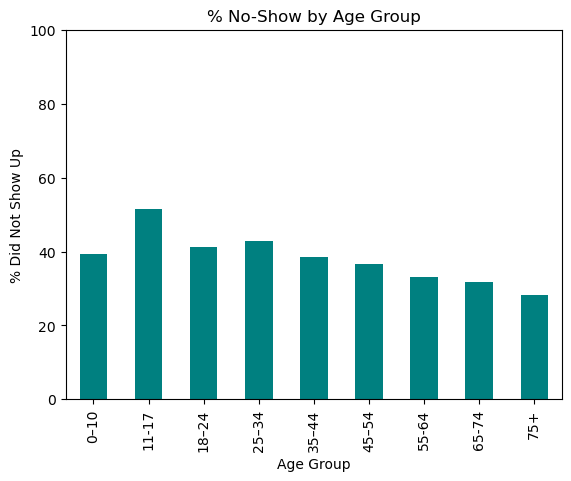

In [181]:
bins = [0, 11, 18, 25, 35, 45, 55, 65, 75, 100]
labels = ['0–10', '11-17', '18–24', '25–34', '35–44', '45–54', '55-64', '65-74', '75+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

age_pct = df.groupby('AgeGroup', observed=False)['NoShow'].mean() * 100
age_pct.plot(kind='bar', color='teal')
plt.title('% No-Show by Age Group')
plt.ylabel('% Did Not Show Up')
plt.xlabel('Age Group')
plt.ylim(0, 100)
plt.show()

We can see a general trend that the NoShow rate decreases as the age increases. This implies that the older the person, the more responsible they would treat their appointments.

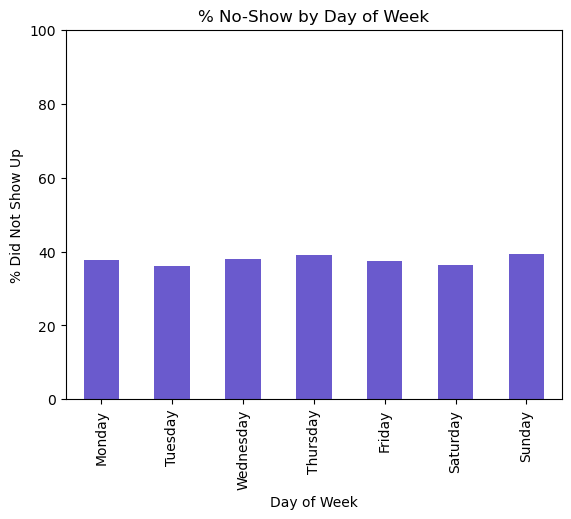

In [182]:
day_pct = df.groupby('DayOfWeek')['NoShow'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
) * 100

day_pct.plot(kind='bar', color='slateblue')
plt.title('% No-Show by Day of Week')
plt.ylabel('% Did Not Show Up')
plt.xlabel('Day of Week')
plt.ylim(0, 100)
plt.show()

We see that day of week does not impact the NoShow rate either.

For these, we notice that the age can potentially affect the probability of NoShow. For gender, day of week, neighborhood it's not really thay evident.

But let's do logistic regression (again) for more reliability.

In [ ]:
X_2 = pd.get_dummies(df[['Gender', 'Neighborhood', 'DayOfWeek', 'Age']], drop_first=True)

X_2 = X_2.astype(float)

X_2 = sm.add_constant(X_2)

# y = df['NoShow'] # we have already defined it above

model_2 = sm.Logit(y, X_2).fit()
print(model_2.summary())

Optimization terminated successfully.
         Current function value: 0.657683
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 NoShow   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4982
Method:                           MLE   Df Model:                           17
Date:                Wed, 16 Apr 2025   Pseudo R-squ.:                0.007234
Time:                        21:11:25   Log-Likelihood:                -3288.4
converged:                       True   LL-Null:                       -3312.4
Covariance Type:            nonrobust   LLR p-value:                 8.817e-05
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0109      0.146     -0.074      0.941      -0.298      

I don't really want to see this for each category, so I'll use likelyhood ratio test to get a sense of the patameters in general to see if the model improves with these parameters. 

In [184]:
cols_1 = ['Gender', 'Neighborhood', 'DayOfWeek', 'AgeGroup']

for col in cols_1:
    X_full = pd.get_dummies(df[[col]], drop_first=True)
    X_full = sm.add_constant(X_full)
    X_full = X_full.astype(float)

    X_null = pd.DataFrame({'const': 1}, index=df.index)

    model_full = sm.Logit(y, X_full).fit(disp=0)
    model_null = sm.Logit(y, X_null).fit(disp=0)

    # 4. Likelihood Ratio Test
    LR_stat = 2 * (model_full.llf - model_null.llf)
    df_diff = model_full.df_model - model_null.df_model
    p_value = chi2.sf(LR_stat, df_diff)

    print(f'LR test for {col}: p = {p_value:.5f}')

LR test for Gender: p = 0.40380
LR test for Neighborhood: p = 0.38151
LR test for DayOfWeek: p = 0.81568
LR test for AgeGroup: p = 0.00001


We see that there is a statistical significance of the age parameter, but not for gender, neighborhood and day of week (supported by the barplots).

### Previous NoShows, waiting time

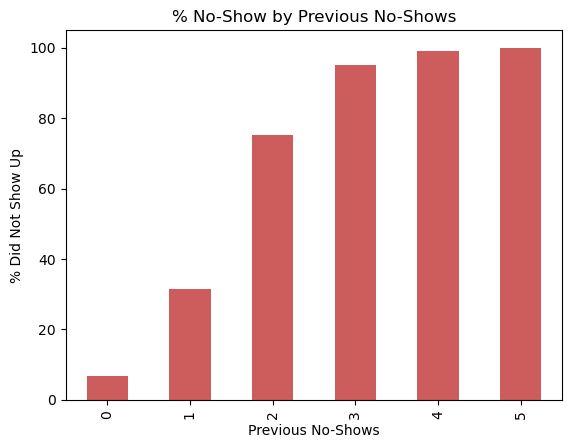

In [185]:
prev_pct = df.groupby('PreviousNoShows')['NoShow'].mean() * 100
prev_pct.plot(kind='bar', color='indianred')
plt.title('% No-Show by Previous No-Shows')
plt.ylabel('% Did Not Show Up')
plt.xlabel('Previous No-Shows')
plt.show()

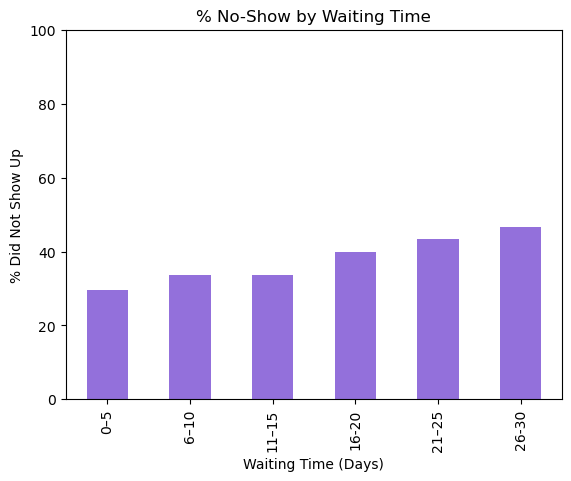

In [186]:
bins = [0, 6, 11, 16, 21, 26, 1000]
labels = ['0–5', '6–10', '11–15', '16-20', '21–25', '26-30']
df['WaitingTimeGroup'] = pd.cut(df['WaitingTime'], bins=bins, labels=labels, right=False)

wait_pct = df.groupby('WaitingTimeGroup', observed=False)['NoShow'].mean() * 100
wait_pct.plot(kind='bar', color='mediumpurple')
plt.title('% No-Show by Waiting Time')
plt.ylabel('% Did Not Show Up')
plt.xlabel('Waiting Time (Days)')
plt.ylim(0, 100)
plt.show()

We see that PreviousNoShows significantly affects the NoShow percentage, we also see that waiting time also affects NoShow.

Let's now run logistic regression to assess it statistically.

In [187]:
X_3 = pd.get_dummies(df[['PreviousNoShows', 'WaitingTime']], drop_first=True)
X_3 = sm.add_constant(X_3)
X_3 = X_3.astype(float)

#y = df['NoShow'].astype(int) #we already defined it above

model_3 = sm.Logit(y, X_3).fit()
print(model_3.summary())

Optimization terminated successfully.
         Current function value: 0.406739
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 NoShow   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4997
Method:                           MLE   Df Model:                            2
Date:                Wed, 16 Apr 2025   Pseudo R-squ.:                  0.3860
Time:                        21:11:31   Log-Likelihood:                -2033.7
converged:                       True   LL-Null:                       -3312.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.9605      0.102    -29.099      0.000      -3.160      -2.761
PreviousNoShow

This shows that PreviousNoShows and WaitingTime have a statistically significant affect on the NoShow probability.

We can interpret this as following: if the more times the person has missed their appointments before, the higher chances they will miss their appointment again. Also, the more days the person had to wait for their appointment, the more likely they will miss their appointment (can be they forgot about it or their health concern is not relevant anymore).

Let's also check if the appointment hour affects whether the person will miss their appointment. For this, let's divide the appointment time by hour group, i.e. 9.00-10.00, 10.00-11.00, etc.

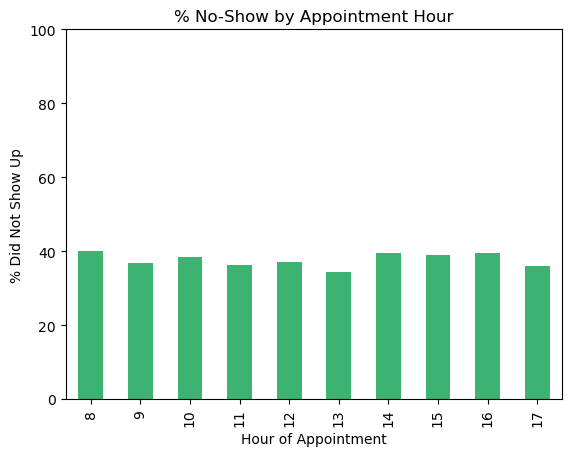

In [188]:
df['AppointmentTime_dt'] = pd.to_datetime(df['AppointmentTime'], format='%H:%M')
df['HourGroup'] = df['AppointmentTime_dt'].dt.hour

appt_pct = df.groupby('HourGroup')['NoShow'].mean() * 100
appt_pct.plot(kind='bar', color='mediumseagreen')
plt.title('% No-Show by Appointment Hour')
plt.ylabel('% Did Not Show Up')
plt.xlabel('Hour of Appointment')
plt.ylim(0, 100)
plt.show()

We don't see any significant pattern (tho we see that the percentage of NoShow decreases just a bit at 13.00 - usually lunch hour and 17.00 - and of work day, but again - this is not really significant)

In [189]:
X_4 = pd.get_dummies(df[['HourGroup']], drop_first=True)
X_4 = sm.add_constant(X_4)
X_4 = X_4.astype(float)

#y = df['NoShow'].astype(int) #we have already defined this above

model_4 = sm.Logit(y, X_4).fit()
print(model_4.summary())

Optimization terminated successfully.
         Current function value: 0.662472
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 NoShow   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4998
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Apr 2025   Pseudo R-squ.:               5.342e-06
Time:                        21:11:42   Log-Likelihood:                -3312.4
converged:                       True   LL-Null:                       -3312.4
Covariance Type:            nonrobust   LLR p-value:                    0.8508
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4792      0.131     -3.668      0.000      -0.735      -0.223
HourGroup     -0.0019      0.

The logistic regression model doesn't show any significance either.

## Adding new parameters

Now, let's create a column, which will show which month the appointment was.

In [ ]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])  # Convert to datetime if not already
df['AppointmentMonth'] = df['AppointmentDay'].dt.month.astype(str).str.zfill(2) 

In [192]:
df['AppointmentMonth'].unique()

array(['11', '12', '10', '09', '07', '08'], dtype=object)

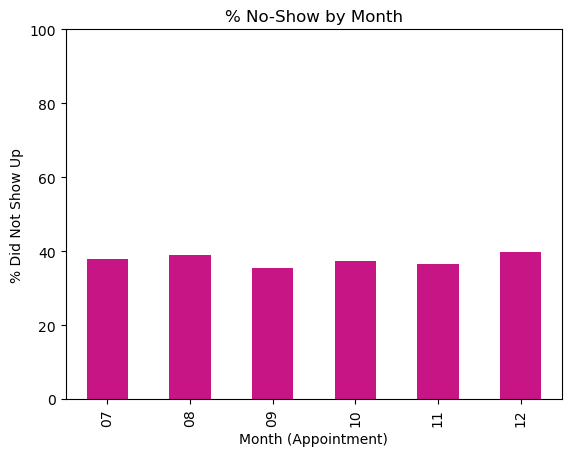

In [193]:
# Calculate % NoShow per month
month_pct = df.groupby('AppointmentMonth')['NoShow'].mean().sort_index() * 100

month_pct.plot(kind='bar', color='mediumvioletred')
plt.title('% No-Show by Month')
plt.ylabel('% Did Not Show Up')
plt.xlabel('Month (Appointment)')
plt.ylim(0, 100)
plt.show()

Now let's see, maybe during thanksgiving and Christmas weeks, the NoShow probability is higher?

In [194]:
# Create a holiday label column
df['HolidayWeek'] = 'Regular'

# Thanksgiving week (e.g., Nov 20–26, 2023)
df.loc[df['AppointmentDay'].between('2023-11-20', '2023-11-26'), 'HolidayWeek'] = 'Thanksgiving Week'

# Christmas week (Dec 24–31)
df.loc[df['AppointmentDay'].between('2023-12-24', '2023-12-31'), 'HolidayWeek'] = 'Christmas Week'

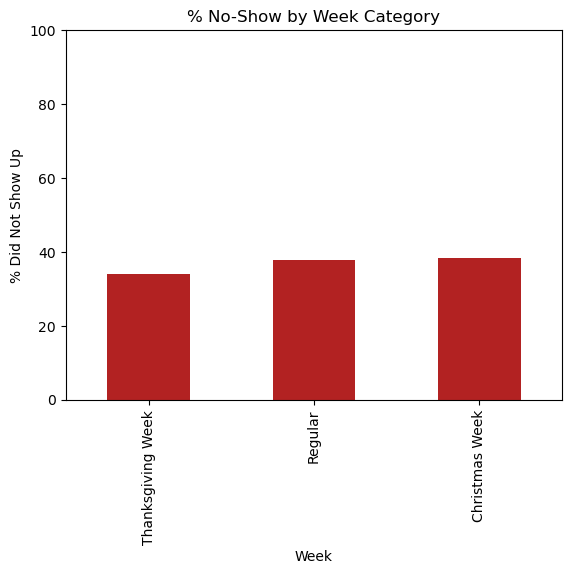

In [195]:
holiday_pct = df.groupby('HolidayWeek')['NoShow'].mean().sort_values() * 100

holiday_pct.plot(kind='bar', color='firebrick')
plt.title('% No-Show by Week Category')
plt.ylabel('% Did Not Show Up')
plt.xlabel('Week')
plt.ylim(0, 100)
plt.show()

We don't really see any correlation here either.

### Creating a heatmap to assess Spearman correlation along the features

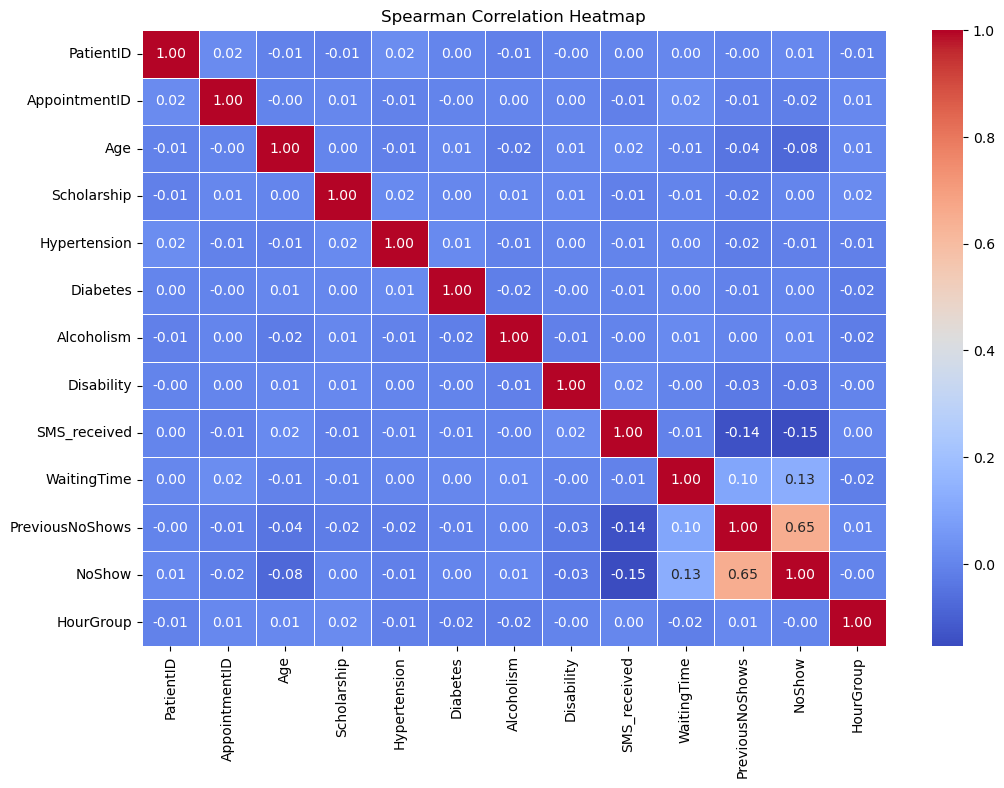

In [196]:
# Spearman correlation matrix
spearman_corr = df.corr(method='spearman', numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Heatmap')
plt.show()

This heatmap shows us that the strongest predictor of NoShow is PreviousNoShows (the heatmap shows 0.65 - which is a strong-ish positive correlation - the more PreviousNoShows, the bigger probability of NoShow - which is actually logical and expectable).

We also see that SMS_received and NoShow have correlation coefficient of -0.15 (it's not much, but still something), which indicates that receiving SMS reduces the chances of NoShow.

Additionally, there is a minor correlation between Waiting Time (how many days advanced the booking was made) and NoShow, which indicates that the more the patient had to wait for their appointment, the higher chances they will miss their appointment. 

# Developing a model for NoShow prediction

## XgBoost

In [7]:
df['NoShow'].value_counts()

NoShow
0    3116
1    1884
Name: count, dtype: int64

So, in our data we have significantly more NoShow = 0 than NoShow = 1, which can result in worse recall/precision where NoShow = 1. We can use the parameter scale_pos_weight to deal with the class imbalance.

Let's see the relationship between NoShow = 0 count and NoShow = 1 count.

In [223]:
3116 / 1884

1.653927813163482

Using exactly 1.65 improves the recall of NoShow = 1, but hurts its precision, as well as recall of NoShow = 0. So, let's try to tune it.

I'm gonna use parameters WaitingTime, PreviousNoShows, Age, disability and SMS_received, as these were shown to have possible correlation with the NoShow rate.

I pick test_size = 0.2, so 80% of my data will be used for training the model and 20% for test. Here, we also split the data in train (X_train, y_train) and test (X_test, y_test), where X is for parameters and y for 'NoShow'.

In [154]:
features = ['WaitingTime', 'PreviousNoShows', 'Age', 'Disability', 'SMS_received']
X, y = df[features], df['NoShow']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Here, I'm gonna use RandomizedSearchCV (CV for cross-validation) in order to determine the best parameters I can use for my Xgboost model.

I'm searching the optimal values for parameters max_depth, learning_rate and scale_pos_weight.

P.s. I've tried to use Grid Search as well, but Randomized Search provided better results for the model. 

In [ ]:
# We want to find parameter scores for the optimum F1 score for the positive class NoShow=1
f1_class1 = make_scorer(f1_score, pos_label=1)

param_dist = {
    "max_depth": [2, 3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
    "scale_pos_weight": [1.0, 1.2, 1.3, 1.5, 1.7]
}

xgb_base = xgb.XGBClassifier(
    n_estimators=500,
    eval_metric='logloss',
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring=f1_class1,
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
print("Best params:", search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'scale_pos_weight': 1.7, 'max_depth': 3, 'learning_rate': 0.01}


Here I apply the XgBoost model, including the parameters Randomized Search has suggested. I also tuned the threshold of y prediction probability to be 0.51, as it provided better results.

In [9]:
model = xgb.XGBClassifier(
    n_estimators=500,  
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=10,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=1.7
)

print("Holdout Evaluation (train/test split):")
model.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)], verbose=False)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
y_pred_custom = (y_prob >= 0.51).astype(int)  

print(classification_report(y_test, y_pred_custom))
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print("F1 score:", f1_score(y_test, y_pred_custom))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Holdout Evaluation (train/test split):
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       623
           1       0.76      0.72      0.74       377

    accuracy                           0.81      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.81      0.81      0.81      1000

Accuracy: 0.807
F1 score: 0.7381275440976933
ROC AUC: 0.8756828216340033


I also used the model with slightly different parameter values.

In [150]:
model_man = xgb.XGBClassifier(
    n_estimators=500,  
    learning_rate=0.05,
    early_stopping_rounds=10,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=1.3
)

print("Holdout Evaluation (train/test split):")
model_man.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)], verbose=False)

y_pred_man = model_man.predict(X_test)
y_prob_man = model_man.predict_proba(X_test)[:, 1]
y_pred_custom_man = (y_prob_man >= 0.51).astype(int)  

print(classification_report(y_test, y_pred_custom_man))
print("Accuracy:", accuracy_score(y_test, y_pred_custom_man))
print("F1 score:", f1_score(y_test, y_pred_custom_man))
print("ROC AUC:", roc_auc_score(y_test, y_prob_man))

Holdout Evaluation (train/test split):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       623
           1       0.79      0.69      0.74       377

    accuracy                           0.81      1000
   macro avg       0.81      0.79      0.80      1000
weighted avg       0.81      0.81      0.81      1000

Accuracy: 0.815
F1 score: 0.7383309759547383
ROC AUC: 0.8698732495710411


I have decided to move on with the parameters RandomizedSearchCV provided, as it gave better recall for NoShow=1 (0.72 vs 0.69) and slightly higher ROC AUC value (The model has an 87% chance of ranking a random no-show patient higher than a random show-up patient - basically, the model does not rank randomly).

I also used SHAP to see how much did my parameters contribute to the NoShow prediction.

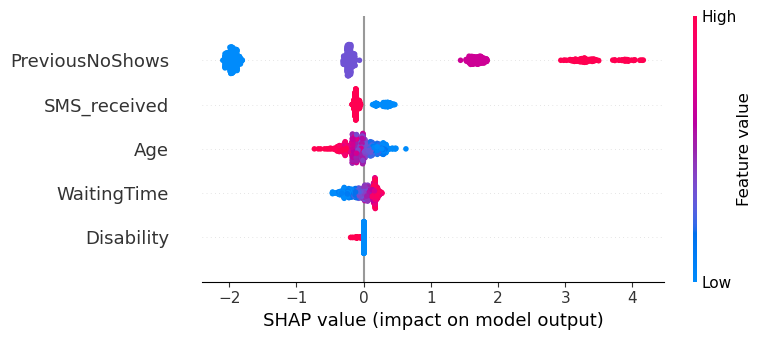

In [15]:
explainer = shap.Explainer(model, X_train)  
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

The plot shows that the biggest PreviousNoShows parameters has the greatest impact on the NoShow prediction, while Disability has the smallest impact on the NoShow prediction.

Also, this is a waterfall plot, which generates the SHAP values for a specific patient (we choose by changing the patient_index).

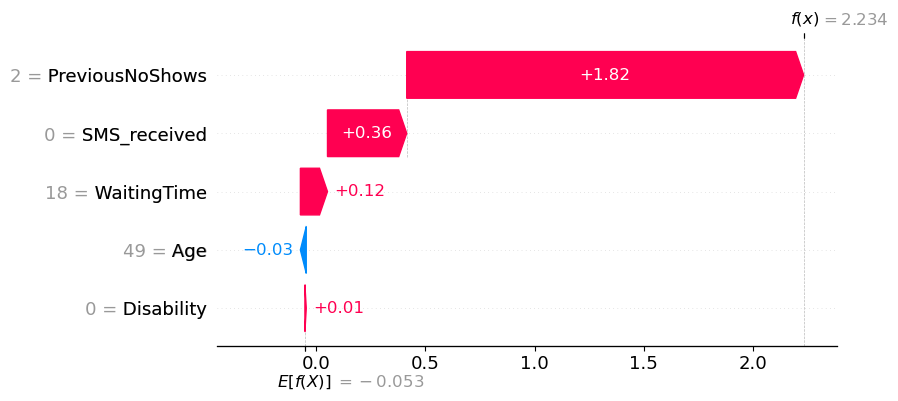

In [151]:
patient_index = 11  # index of the client from the testing set
shap.plots.waterfall(shap_values[patient_index])

For patient_index = 11, the plot shows that they have PreviousNoShow = 2, which pushed the prediction up (more likely to miss), SMS_received = 0 (didn't received an SMS) pushed the prediction up as well, etc.

I also did run the model with Cross-Validation (with the same parameters) to see whether it improves the model.

In [155]:
model_cv = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42, 
    scale_pos_weight=1.7
)

print("Cross-Validation Evaluation:")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precision_scores = cross_val_score(model_cv, X, y, cv=cv, scoring='precision')
recall_scores = cross_val_score(model_cv, X, y, cv=cv, scoring='recall')
f1_scores = cross_val_score(model_cv, X, y, cv=cv, scoring='f1')
auc_scores = cross_val_score(model_cv, X, y, cv=cv, scoring='roc_auc')

print("Precision scores:", precision_scores)
print("Mean Precision:", precision_scores.mean())

print("Recall scores:", recall_scores)
print("Mean Recall:", recall_scores.mean())

print("F1 scores:", f1_scores)
print("Mean F1:", f1_scores.mean())

print("\nROC AUC scores:", auc_scores)
print("Mean ROC AUC:", auc_scores.mean())

Cross-Validation Evaluation:
Precision scores: [0.79635258 0.76487252 0.71315789 0.7591623  0.80346821]
Mean Precision: 0.7674027022654669
Recall scores: [0.69680851 0.71618037 0.71883289 0.76923077 0.73740053]
Mean Recall: 0.727690614594503
F1 scores: [0.74326241 0.73972603 0.71598415 0.76416337 0.76901798]
Mean F1: 0.7464307880384969

ROC AUC scores: [0.88545929 0.86850654 0.85662342 0.89152982 0.90011751]
Mean ROC AUC: 0.8804473165645389


Here, ROC AUC score increased to 88% (compared to the 87% by the previous model), recall for NoShow=1 became 73% (compared to 72%), F1 score became 74.6% (compared to 73.8%) and precision became 76.7% (compared to 76%).
So, we see that using cross-validation model has helped the model.

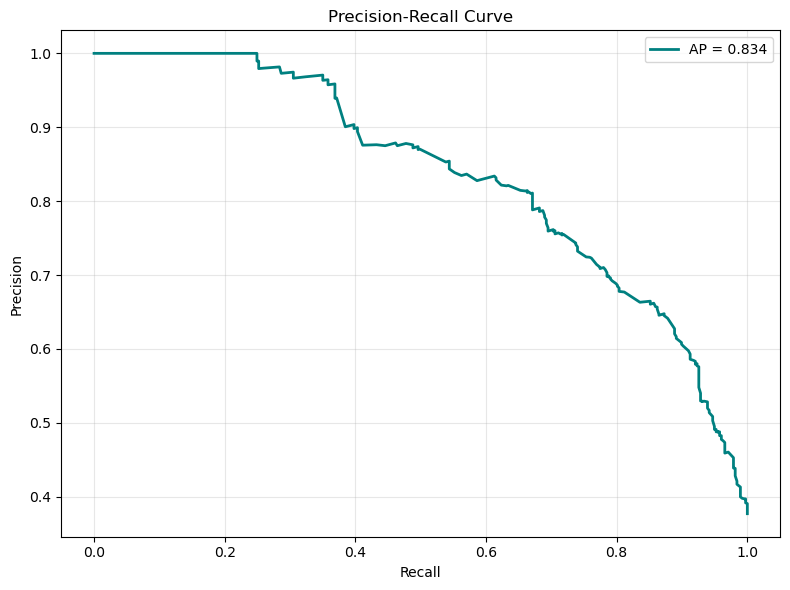

In [157]:
y_scores = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

ap = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='teal', linewidth=2, label=f'AP = {ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The precision-recall curve above show how the recall and precision change with regards to each other, e.g. how the precision will change if we increase the recall. This plot is useful when we want to balance out the recall and precision scores (e.g. which one do we prioritize).

This plot illustrates that increasing the true positive rate (recall) leads to the increase of false positives (precision declines) and vice versa.

We can use this plot to prioritize which results we value more, i.e. if we want to avoid no-shows better - use higher recall, if we want to avoid the false alerts - use higher precision.

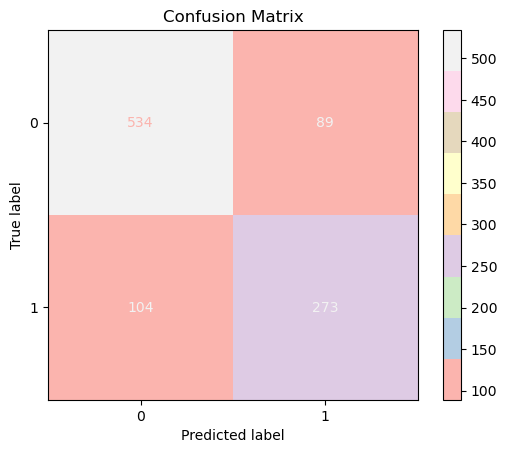

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Pastel1')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

This confusion matrix shows the model performance of the test set. 534 is how many true negatives (correctly predicted NoShow=0) the model has predicted and 273 true positives (correctly predicted NoShow=1). Though we have 104 FPs (classified as NoShow=1, even though it's actually NoShow=0) and 89 FNs (classified as NoShow=0, but is actually NoShow=1).  

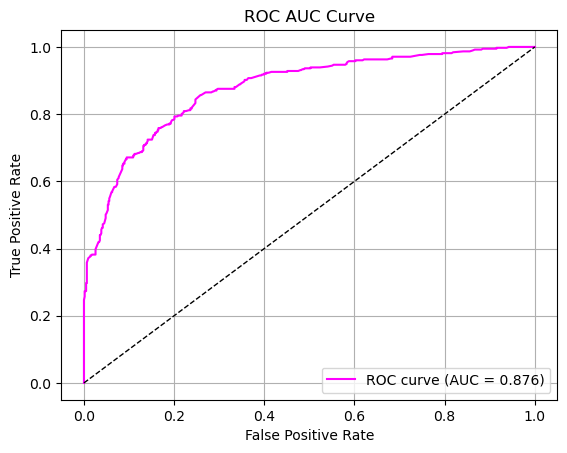

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", color='magenta')
plt.plot([0, 1], [0, 1], 'k--', lw=1)  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

The ROC AUC curve shows 0.876, which is good for the model (discussed above). If it was 0.5, it would mean that the model predicts NoShow absolutely randomly.

### Logistic regression model

Let's also try Logistic Regression model and compare the results with the results of XgBoost.

In [ ]:
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
y_prob_lr = model_lr.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lr)}")

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       623
           1       0.73      0.76      0.74       377

    accuracy                           0.80      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.80      0.80      0.80      1000

Accuracy: 0.8
F1 Score: 0.7402597402597403
ROC AUC: 0.8762278016443069


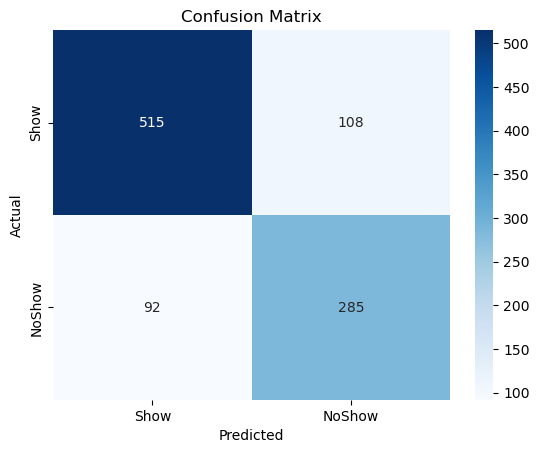

In [159]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Show', 'NoShow'], yticklabels=['Show', 'NoShow'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

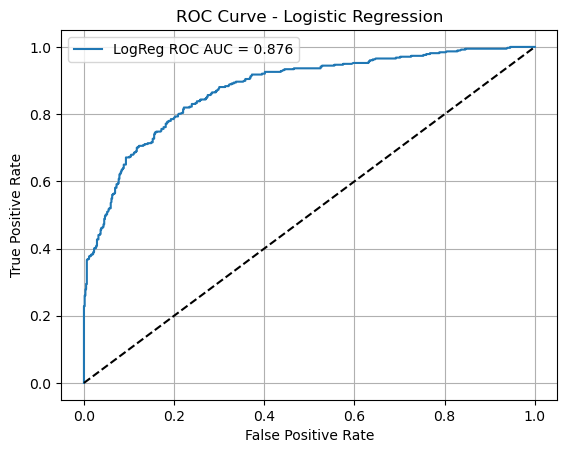

In [162]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
plt.figure()
plt.plot(fpr, tpr, label=f"LogReg ROC AUC = {roc_auc_score(y_test, y_prob_lr):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

# Conclusion

The initial analysis showed that 5 parameters had correlation with the NoShow values (Age, SMS_received, Disability, PreviousNoShows, WaitingTime).
I have used these parameters for my classification models (I had tried to generate some parameters by myself, but they didn't show any correlation with the NoShow prediction). 

I have tried 2 classification models: Xgboost (the model with cross-validation) and Logistic Regression. They both showed strong ROC AUC score (Xgboost - 88%, LR - 87.6%). The main difference is that LR model had higher recall for NoShow=1 than Xgboost (76% vs 73%). However, Xgboost showed higher precision than LR (77% vs 73%) and slightly higher ROC AUC score. Hence, in order to pick which model is the best, we need to decide what we prioritize more - recall (catching as many NoShows as possible) or precision (avoiding false alarms) + more accuracy in prediction. 